# 1. Introduction
This notebook is part of a machine learning for healthcare exercise, focusing on using the Responsible AI (RAI) package to enhance clinical decision-making. The toolkit will be used to analyze opioid use disorder (OD) risk, with three key objectives:

1. Analyze Errors and Explore Interpretability of Models: We will run Interpret-Community’s global explainers to generate feature importance insights and visualize model errors with the Error Analysis dashboard

2. Plan real-world action through counterfactual and causal analysis: By leveraging counterfactual examples and causal inference, we will explore decision-making strategies based on opioid prescription patterns and patient comorbidities to understand possible interventions and their impacts

3. Assess addiction risk predictions: A classification model trained on patient-level features (income, surgeries, opioid prescription days, and comorbidities A–V) will be evaluated to examine its performance in predicting risk of opioid use disorder and to inform prevention strategies

**The goal is to provide non-trivial insights for clinical decision making, leveraging machine learning paired with responsible AI tools, to improve patient outcomes in the healthcare context.**

Based on notebooks from the [Responsible AI toolkit](https://github.com/microsoft/responsible-ai-toolbox/tree/main/notebooks)


**CURRENT POTENTIAL HYPOTHESIS (S)**

--> If a patient is diagnosed with asthma, they would be diagnosed with lung cancer faster (due to more frequent checkups), leading to a higher chance of being diagnosed within stage 1 and 2 and therefore, a higher chance of survival. 

--> If a patient is diagnosed with cirrhosis, they will be less likely to survive if undergoing chemotherapy/radiation (as this would jeopordize the treatment). 

--> If a patient has smoked in the past to present, it will reduce a patients chances of surviving lung cancer. 


**WHAT WE ARE LOOKING FOR**
- biggest indicators of a patients survival or lack of. 

# 2. Data Set Characteristics

Number of Instances: patient-level records (rows)

Number of Attributes: 15 predictive attributes and 1 target class

Attribute Information:
- age: age of patient at time of diagnosis
- gender: male/female
- country: country where patient resides at time of diagnosis
- diagnosis_date: date of patients diagnosis (year-month-day)
- cancer_stage: stage of cancer at time of diagnosis (1,2,3,4)
- family_history: yes/no of a family history of cancer
- smoking_status: smoking status of patient (1: current smoker, 2: former smoker, 3: never smoked, 4: passive smoker)
- bmi: Body Mass Index of patient at time of diagnosis
- cholesterol_level: integer value of cholesterol_level
- hypertension: indicates if patient has high blood pressure (1: yes, 0: no)
- asthma: indicates if patient has asthma (1: yes, 0: no)
- cirrhosis: indicates if patient has cirrhosis (1: yes, 0: no)
- other_cancer: indicates if patient has another form of cancer, aside from original diagnosis (1: yes, 0: no)
- treatment_type: type of treatment patient received (1: surgery, 2: chemotherapy, 3: radiation, 4: combined)
- end_treatment_date: date on which patient completed their treatment or died
- survived (target): indicates if patient lived or died (1: yes, 0:no)


class:
- survived = 1: patient who survived cancer treatment 
- survived = 0: patient who died during cancer treatment (due to cancer)


# 3. Setup
- responsibleai and raiwidgets provide RAIInsights and the dashboard
- fairlearn provides fairness metrics and mitigation algorithms used under the hood
- imbalanced-learn offers resampling utilities if you want to experiment with imbalance mitigation

In [2]:
import numpy
import scipy
print("NumPy:", numpy.__version__)
print("SciPy:", scipy.__version__)


NumPy: 1.26.2
SciPy: 1.15.2


In [3]:
# 1. Setup

from pathlib import Path
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, kendalltau, chi2_contingency, ttest_ind, mannwhitneyu
from statsmodels.stats.proportion import proportion_confint
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from IPython.display import display, Markdown
import opendatasets as od 
import seaborn as sns
from itertools import combinations 
from yellowbrick.features import Rank2D

# Scikit-learn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.dummy import DummyClassifier
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay
from sklearn.feature_selection import VarianceThreshold
from sklearn.base import clone
from sklearn.metrics import (
    roc_auc_score,           # Measures the ability of the model to distinguish between classes (higher is better)
    average_precision_score, # Computes the average precision for precision-recall curves (useful for imbalanced data)
    brier_score_loss,        # Measures the mean squared difference between predicted probabilities and actual outcomes (lower is better)
    log_loss,                # Penalizes false classifications with a focus on probability estimates (lower is better)
    confusion_matrix,        # Summarizes true/false positives/negatives for classification predictions
    precision_score,         # Proportion of positive identifications that were actually correct (TP / (TP + FP))
    recall_score,            # Proportion of actual positives that were correctly identified (TP / (TP + FN))
    RocCurveDisplay,         
    PrecisionRecallDisplay,
    f1_score,
    r2_score, 
    mean_squared_error,
    classification_report
)
# Fairness utilities
try:
    from fairlearn.metrics import (
        MetricFrame,
        selection_rate,
        true_positive_rate,
        false_positive_rate,
    )
    _FAIRLEARN = True
except Exception:
    _FAIRLEARN = False

# Responsible AI dashboard
try:
    from responsibleai import RAIInsights
    from raiwidgets import ResponsibleAIDashboard
    _RAI = True
except Exception:
    _RAI = False

# Course utilities for transparency and thresholding
from utils import (
    positive_scores,
    auc_report,
    tradeoff_table,
    pick_threshold_cost,
    pick_threshold_recall_floor,
    pick_threshold_workload,
    summary_at_threshold,
    plot_recall_floor_curves,
    plot_cumulative_recall_at_threshold,
    plot_topk_at_threshold,
)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


# 4. Data Load & preparation

In [8]:
# od.download(
#     "https://www.kaggle.com/datasets/amankumar094/lung-cancer-dataset")


In [4]:
# Path to your CSV (update if needed for your system)
DATA_PATH = "./Data/lung_cancer_dataset_med.csv"

df_raw = pd.read_csv(DATA_PATH)
print("Shape:", df_raw.shape)
df_raw.head(15)

Shape: (890000, 17)


,id,age,gender,country,diagnosis_date,cancer_stage,family_history,smoking_status,bmi,cholesterol_level,hypertension,asthma,cirrhosis,other_cancer,treatment_type,end_treatment_date,survived
0,1,64.0,Male,Sweden,2016-04-05,Stage I,Yes,Passive Smoker,29.4,199,0,0,1,0,Chemotherapy,2017-09-10,0
1,2,50.0,Female,Netherlands,2023-04-20,Stage III,Yes,Passive Smoker,41.2,280,1,1,0,0,Surgery,2024-06-17,1
2,3,65.0,Female,Hungary,2023-04-05,Stage III,Yes,Former Smoker,44.0,268,1,1,0,0,Combined,2024-04-09,0
3,4,51.0,Female,Belgium,2016-02-05,Stage I,No,Passive Smoker,43.0,241,1,1,0,0,Chemotherapy,2017-04-23,0
4,5,37.0,Male,Luxembourg,2023-11-29,Stage I,No,Passive Smoker,19.7,178,0,0,0,0,Combined,2025-01-08,0
5,6,50.0,Male,Italy,2023-01-02,Stage I,No,Never Smoked,37.6,274,1,0,0,0,Radiation,2024-12-27,0
6,7,49.0,Female,Croatia,2018-05-21,Stage III,Yes,Passive Smoker,43.1,259,0,0,0,0,Radiation,2019-05-06,1
7,8,51.0,Male,Denmark,2017-02-18,Stage IV,Yes,Former Smoker,25.8,195,1,1,0,0,Combined,2017-08-26,0
8,9,64.0,Male,Sweden,2021-03-21,Stage III,Yes,Current Smoker,21.5,236,0,0,0,0,Chemotherapy,2022-03-07,0
9,10,56.0,Male,Hungary,2021-11-30,Stage IV,Yes,Current Smoker,17.3,183,1,0,0,1,Surgery,2023-11-29,0


## 4.1. Basic cleaning and schema alignment

In [ ]:
TARGET = "survived"

df = df_raw.copy()
df = df.sample(frac=0.5, random_state=42)  # 50%

# 1) Parse dates BEFORE subtracting
df["diagnosis_date"] = pd.to_datetime(df["diagnosis_date"], errors="coerce")
df["end_treatment_date"] = pd.to_datetime(df["end_treatment_date"], errors="coerce")

# 2) Treatment duration (days)
df["treatment_duration_days"] = (df["end_treatment_date"] - df["diagnosis_date"]).dt.days

# guardrails: drop invalid/negative durations
df = df[df["treatment_duration_days"].notna()]
df = df[df["treatment_duration_days"] >= 0]

# 3) Region from country 
region_map = {
    "Sweden":"North","Denmark":"North","Finland":"North","Ireland":"North",
    "Netherlands":"West","Belgium":"West","Luxembourg":"West","France":"West","Germany":"West","Austria":"West",
    "Italy":"South","Spain":"South","Portugal":"South","Greece":"South","Malta":"South","Cyprus":"South",
    "Poland":"East","Czech Republic":"East","Slovakia":"East","Hungary":"East","Slovenia":"East",
    "Croatia":"East","Romania":"East","Bulgaria":"East","Estonia":"East","Latvia":"East","Lithuania":"East"
}
df["region"] = df["country"].map(region_map).fillna("Other")

# 4) Now it’s safe to drop raw/date columns
df.drop(["id","bmi","diagnosis_date","end_treatment_date","country","other_cancer"], axis=1, inplace=True)

# 5) Standardize names
df.columns = [c.strip().replace(" ", "_").replace("-", "_") for c in df.columns]

# 6) Combine comorbidities + smoked flag
df["comorbidities"] = ((df["hypertension"]==1) | (df["cirrhosis"]==1) | (df["asthma"]==1)).astype(int)
df.drop(["hypertension","asthma","cirrhosis"], axis=1, inplace=True)

df["smoked"] = (
    (df["smoking_status"]=="Current Smoker") |
    (df["smoking_status"]=="Former Smoker") |
    (df["smoking_status"]=="Passive Smoker")
)
df.drop(["smoking_status"], axis=1, inplace=True)

# 7) Binary coercion
def to_binary(s: pd.Series) -> pd.Series:
    if s.dtype == "O":
        mapped = s.astype(str).str.strip().str.lower().map({
            "1":1,"0":0,"y":1,"n":0,"yes":1,"no":0,"true":1,"false":0,"male":1,"female":0
        })
        s = pd.to_numeric(mapped, errors="coerce")
    else:
        s = pd.to_numeric(s, errors="coerce")
    return (s.fillna(0) > 0).astype(int)

for col in ["gender","family_history","comorbidities","smoked"]:
    df[col] = to_binary(df[col])

# 8) Stage ordinal
stage_map = {"Stage I":1,"Stage II":2,"Stage III":3,"Stage IV":4}
df["cancer_stage"] = df["cancer_stage"].map(stage_map)

# 9) One-hot encodings (drop_first later if you prefer)
df = pd.get_dummies(df, columns=["treatment_type","region"], drop_first=False)
df.rename(columns={
    "treatment_type_Chemotherapy":"treat_chemo",
    "treatment_type_Combined":"treat_combined",
    "treatment_type_Radiation":"treat_radiation",
    "treatment_type_Surgery":"treat_surgery"
}, inplace=True)

print(df.head(10))


         age  gender  cancer_stage  family_history  cholesterol_level  \
773684  37.0       1             2               0                241   
278119  63.0       0             3               0                162   
810422  63.0       0             3               0                230   
443587  71.0       1             2               0                293   
701478  45.0       0             1               0                173   
100969  54.0       0             4               1                258   
774703  41.0       0             2               0                222   
684391  60.0       1             3               0                195   
612535  51.0       0             2               0                179   
59393   51.0       1             2               1                290   

        survived  treatment_duration_days  comorbidities  smoked  treat_chemo  \
773684         0                      594              0       1            0   
278119         0                  

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 445000 entries, 773684 to 200847
Data columns (total 17 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   age                      445000 non-null  float64
 1   gender                   445000 non-null  int64  
 2   cancer_stage             445000 non-null  int64  
 3   family_history           445000 non-null  int64  
 4   cholesterol_level        445000 non-null  int64  
 5   survived                 445000 non-null  int64  
 6   treatment_duration_days  445000 non-null  int64  
 7   comorbidities            445000 non-null  int64  
 8   smoked                   445000 non-null  int64  
 9   treat_chemo              445000 non-null  uint8  
 10  treat_combined           445000 non-null  uint8  
 11  treat_radiation          445000 non-null  uint8  
 12  treat_surgery            445000 non-null  uint8  
 13  region_East              445000 non-null  uint8  
 14 

### 4.1 Feature Engineering (takeaways from EDA notebook)

In [7]:
#treatment x cancer_stage 
for t in ["treat_surgery"]:
    df[f"{t}_stage"] = df[t] * df["cancer_stage"]   

#comorbidities x treatment as this can change toleration to chemo/radiation
for t in ["treat_chemo","treat_surgery","treat_radiation"]:
    df[f"{t}_comorbid"] = df[t]*df["comorbidities"]   

#smoked x treatment_type as it could have differnt outcomes with chemo/radiation
for t in ["treat_chemo", "treat_radiation"]:
    df[f"{t}_smoked"] = df[t] * df["smoked"]


# 5. Training, Validation and Testing - 80/15/5 stratified split

Train–test split

- Prevents “peeking” at data and overestimating performance
- Mimics real-world deployment where models face unseen patients
- Always evaluate on data not used for training

In [ ]:
# Define target and feature sets consistently with data preparation
target_col = "survived"

# Define numeric columns (continuous features)
num_cols = ["age", "cholesterol_level", "treatment_duration_days"]

# Define binary/categorical columns (after one-hot encoding and binary transformations)
cat_like_binary_cols = [
    'gender', 'family_history', 'comorbidities', 'smoked',
    'cancer_stage',
    'treat_chemo', 'treat_combined', 'treat_radiation', 'treat_surgery',
    'region_East', 'region_North', 'region_South', 'region_West',
    'treat_surgery_stage',
    'treat_chemo_comorbid', 'treat_surgery_comorbid', 'treat_radiation_comorbid',
    'treat_chemo_smoked', 'treat_radiation_smoked'
]

# Filter to only include columns that actually exist in df
num_cols = [c for c in num_cols if c in df.columns]
cat_like_binary_cols = [c for c in cat_like_binary_cols if c in df.columns]

# Create feature matrix X and target vector y
X = df.drop(columns=[target_col])

# Target: Predicting SURVIVAL probability
# y=1 means patient SURVIVED (positive outcome)
# y=0 means patient DIED (negative outcome)
# Note: High predicted probability = High survival chance = Good outcome
y = df[target_col].copy()

print(f"Features in X: {X.columns.tolist()}")
print(f"Number of features: {X.shape[1]}")
print(f"\nTarget distribution (y=1 means SURVIVED, y=0 means DIED):")
print(f"  Survived (y=1): {y.sum()} ({100*y.mean():.1f}%)")
print(f"  Died (y=0): {(1-y).sum()} ({100*(1-y.mean()):.1f}%)")

# 80% train, 20% temp (which splits into 15% validation + 5% test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

# Split temp into validation (15% of total) and test (5% of total)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=RANDOM_STATE
)

# Display shapes and class distributions as a DataFrame
info = {
    "Set": ["Train", "Validation", "Test", "Overall"],
    "X shape": [X_train.shape, X_val.shape, X_test.shape, X.shape],
    "y shape": [y_train.shape, y_val.shape, y_test.shape, y.shape],
    "p(survived=0)": [
        y_train.value_counts(normalize=True).get(0, 0.0),
        y_val.value_counts(normalize=True).get(0, 0.0),
        y_test.value_counts(normalize=True).get(0, 0.0),
        y.value_counts(normalize=True).get(0, 0.0),
    ],
    "p(survived=1)": [
        y_train.value_counts(normalize=True).get(1, 0.0),
        y_val.value_counts(normalize=True).get(1, 0.0),
        y_test.value_counts(normalize=True).get(1, 0.0),
        y.value_counts(normalize=True).get(1, 0.0),
    ],
}

df_info = pd.DataFrame(info)
display(df_info.style.format({"p(survived=0)": "{:.3f}", "p(survived=1)": "{:.3f}"}))

Features in X: ['age', 'gender', 'cancer_stage', 'family_history', 'cholesterol_level', 'treatment_duration_days', 'comorbidities', 'smoked', 'treat_chemo', 'treat_combined', 'treat_radiation', 'treat_surgery', 'region_East', 'region_North', 'region_South', 'region_West', 'treat_surgery_stage', 'treat_chemo_comorbid', 'treat_surgery_comorbid', 'treat_radiation_comorbid', 'treat_chemo_smoked', 'treat_radiation_smoked']
Number of features: 22


,Set,X shape,y shape,p(survived=0),p(survived=1)
0,Train,"(356000, 22)","(356000,)",0.779,0.221
1,Validation,"(66750, 22)","(66750,)",0.779,0.221
2,Test,"(22250, 22)","(22250,)",0.779,0.221
3,Overall,"(445000, 22)","(445000,)",0.779,0.221


## 5.1. Modeling pipeline, training, and calibration

### Setting a baseline
A naive majority-class baseline clarifies the minimum standard any model must beat, highlighting the danger of ignoring minority patients and ensuring improvements carry meaningful weight in healthcare decision making

**ROC AUC**  
- 0.5 → no discrimination
- 0.6–0.7 → poor
- 0.7–0.8 → fair
- 0.8–0.9 → good
- ≥ 0.9 → excellent

**PR AUC**  
- Must be interpreted against event prevalence `p` in the validation set  

Dummy baseline
PR AUC: 0.221
ROC AUC: 0.500
Prevalence p = 0.221  |  PR AUC lift = 1.00× over baseline


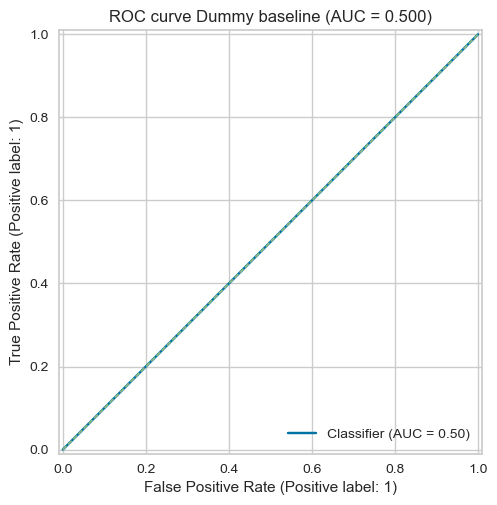

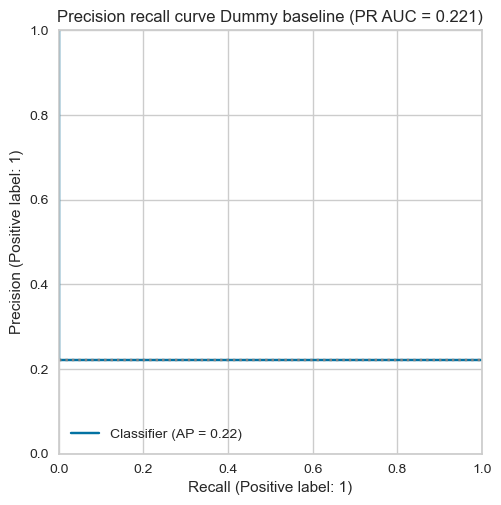

In [9]:
# Baseline: DummyClassifier (majority class)
dummy_clf = DummyClassifier(
    strategy="most_frequent", random_state=RANDOM_STATE)
dummy_clf.fit(X_train, y_train)

proba_val = dummy_clf.predict_proba(X_val)
pos_idx = int(np.where(dummy_clf.classes_ == 1)[0][0])  # index for class "1"
y_score_val = np.asarray(proba_val)[:, pos_idx]

# Evaluate on validation
y_score_val = positive_scores(dummy_clf, X_val)
metrics_dummy = auc_report(
    y_val, y_score_val, name="Dummy baseline", plot=True)

## 5.2. Preprocesing our Pipeline

[Scikit-learn preprocessing](https://scikit-learn.org/stable/api/sklearn.preprocessing.html) standardizes and transforms features for modeling, including scaling, encoding, and imputation. Helping to maintain a consistent data transformation workflow

ADD LASSO REGULARIZATION HERE, AFTER SCALING/BINARY BUT BEFORE LOG REG MODEL 

https://developer.ibm.com/tutorials/awb-lasso-regression-automatic-feature-selection/ 


we might need to deconstruct the pipeline here or consider other options for regularization 

In [10]:
# Preprocessing
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler(with_mean=True, with_std=True))
])

binary_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("bin", binary_transformer, cat_like_binary_cols)
    ],
    remainder="passthrough",  # drop= drops any column not in previously specified, switched to keep engineered variables
    verbose_feature_names_out=False  # keeps original feature names
)



#### 5.2.1 Log Regularization w L1 Penalty - feature importance 

This allowed us to reduce the number of features, almost all of this work is done within EDA and explains why we are working with the features we have now. These are the significant effects on the target (survival) that we will use in the main Log Reg model. 

In [11]:
lasso = LogisticRegression(penalty="l1", solver="liblinear", C=1, class_weight="balanced")


pipe = Pipeline(steps=[
    ("preprocess", preprocess),  
    ("lasso", lasso)  
])
pipe.fit(X_train, y_train)   


feature_names = pipe.named_steps["preprocess"].get_feature_names_out()  
coef = pd.Series(pipe.named_steps["lasso"].coef_.flatten(),index=feature_names)

print("\nNon zero features after l1 regulariztion")   
print(coef[coef != 0])    
# print("Chosen C:", pipe.named_steps["lasso"].C_)



Non zero features after l1 regulariztion
age                         0.001152
cholesterol_level          -0.000035
treatment_duration_days     0.001016
gender                      0.007636
family_history              0.006285
comorbidities               0.009432
smoked                     -0.000945
cancer_stage                0.004410
treat_chemo                 0.008958
treat_combined             -0.012642
treat_radiation            -0.022074
region_East                 0.001440
region_North               -0.012282
region_South               -0.008526
treat_surgery_stage         0.003934
treat_chemo_comorbid       -0.021691
treat_surgery_comorbid     -0.027058
treat_radiation_comorbid    0.024723
treat_chemo_smoked         -0.020794
treat_radiation_smoked      0.000972
dtype: float64


#### 5.2.2 Baseline Log Regression with Variance Filter 

In [12]:
# Logistic Regression baseline with variance filter
base_clf = Pipeline(steps=[
    ("prep", preprocess),
    # Eliminates features with zero variance
    ("varth", VarianceThreshold(threshold=0.0)),
    ("model", LogisticRegression(
        solver="liblinear",  # See details in course material
        class_weight="balanced",  # Adjusts weights for class imbalance - GOOD, we have 20-80
        random_state=RANDOM_STATE,
        max_iter=200
    ))
])

### Basic preliminary model performance check

## 5.3. Improving Model Performance - Testing Multiple Algorithms

**Problem**: Logistic Regression shows poor discrimination (ROC AUC ~0.50, essentially random)

**Solution**: Compare multiple model types to find better class separation
- Random Forest: Captures non-linear relationships and feature interactions
- Gradient Boosting (XGBoost): Often best for tabular medical data
- Logistic Regression with Polynomial Features: Adds interaction terms

We'll compare all models on the validation set and pick the best performer.


In [33]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import PolynomialFeatures

# Define multiple candidate models
models_to_test = {
    "Logistic Regression (baseline)": Pipeline([
        ("prep", preprocess),
        ("varth", VarianceThreshold(threshold=0.0)),
        ("model", LogisticRegression(solver="liblinear", class_weight="balanced", 
                                     random_state=RANDOM_STATE, max_iter=200))
    ]),
    
    "Logistic Regression + Poly Features": Pipeline([
        ("prep", preprocess),
        ("poly", PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)),
        ("model", LogisticRegression(solver="lbfgs", class_weight="balanced", 
                                     random_state=RANDOM_STATE, max_iter=500))
    ]),
    
    "Random Forest": Pipeline([
        ("prep", preprocess),
        ("model", RandomForestClassifier(n_estimators=100, max_depth=10, 
                                        min_samples_split=20, min_samples_leaf=10,
                                        class_weight="balanced", random_state=RANDOM_STATE, 
                                        n_jobs=-1))
    ]),
    
    "Gradient Boosting": Pipeline([
        ("prep", preprocess),
        ("model", GradientBoostingClassifier(n_estimators=100, max_depth=5, 
                                            learning_rate=0.1, subsample=0.8,
                                            random_state=RANDOM_STATE))
    ])
}

# Train and evaluate each model
results = []
for name, model in models_to_test.items():
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train)
    
    # Evaluate on validation set
    y_score_val = positive_scores(model, X_val)
    roc_auc = roc_auc_score(y_val, y_score_val)
    pr_auc = average_precision_score(y_val, y_score_val)
    
    results.append({
        "Model": name,
        "ROC AUC": roc_auc,
        "PR AUC": pr_auc,
        "PR Lift": pr_auc / y_val.mean()
    })
    
    print(f"  ROC AUC: {roc_auc:.3f}")
    print(f"  PR AUC: {pr_auc:.3f}")

# Display comparison table
results_df = pd.DataFrame(results).sort_values("ROC AUC", ascending=False)
display(results_df.style.format({"ROC AUC": "{:.3f}", "PR AUC": "{:.3f}", "PR Lift": "{:.2f}x"}))

# Select best model
best_model_name = results_df.iloc[0]["Model"]
best_model = models_to_test[best_model_name]
print(f"\n✓ Best model: {best_model_name}")
print(f"  Will use this for calibration and threshold selection")



Training Logistic Regression (baseline)...
  ROC AUC: 0.498
  PR AUC: 0.220

Training Logistic Regression + Poly Features...
  ROC AUC: 0.503
  PR AUC: 0.222

Training Random Forest...
  ROC AUC: 0.507
  PR AUC: 0.222

Training Gradient Boosting...
  ROC AUC: 0.506
  PR AUC: 0.223


,Model,ROC AUC,PR AUC,PR Lift
2,Random Forest,0.507,0.222,1.01x
3,Gradient Boosting,0.506,0.223,1.01x
1,Logistic Regression + Poly Features,0.503,0.222,1.01x
0,Logistic Regression (baseline),0.498,0.220,1.00x



✓ Best model: Random Forest
  Will use this for calibration and threshold selection


### Visualize best model performance


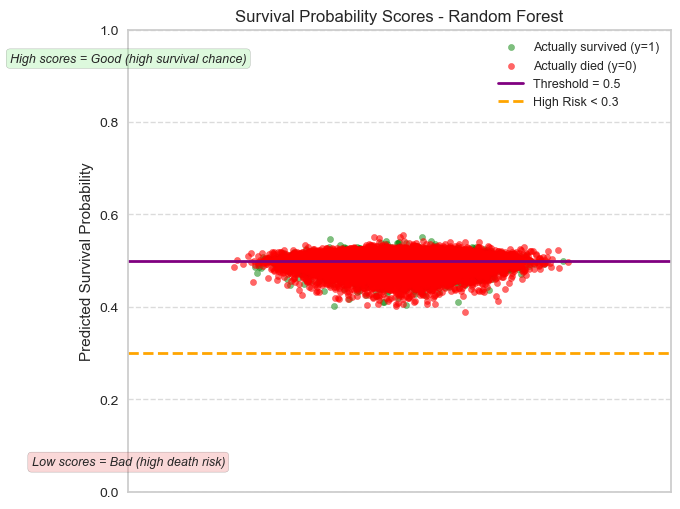

Random Forest
PR AUC: 0.222
ROC AUC: 0.507
Prevalence p = 0.221  |  PR AUC lift = 1.01× over baseline


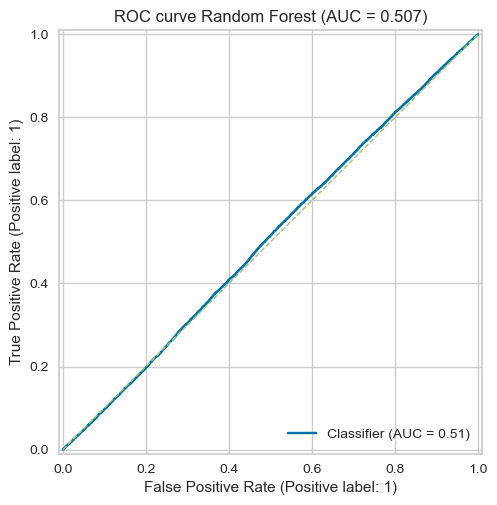

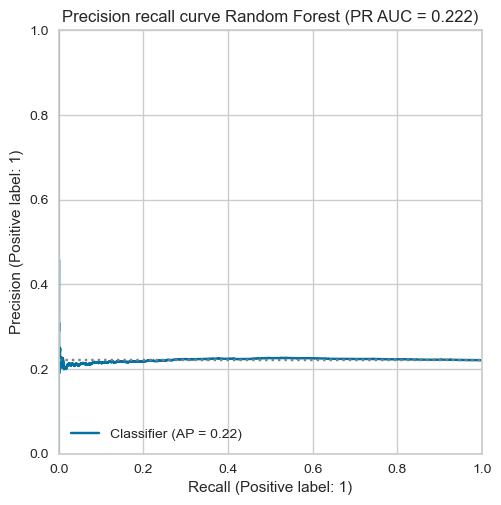

In [35]:
# Visualize the best model's scores
scores = positive_scores(best_model, X_val)
actuals = y_val

# NOTE: Model predicts P(survived=1) = SURVIVAL probability
# High score = High survival chance (good outcome)
# Low score = Low survival chance = High death risk (bad outcome)

# Separate scores by actual outcome
scores_survived = scores[actuals == 1]  # Patients who actually survived (y=1)
scores_died = scores[actuals == 0]      # Patients who actually died (y=0)

# Generate random jitter for the x-axis
jitter_strength = 0.03
jitter_survived = np.random.normal(0, jitter_strength, len(scores_survived))
jitter_died = np.random.normal(0, jitter_strength, len(scores_died))

# Create the plot
fig, ax = plt.subplots(figsize=(7, 6))
scatter_survived = ax.scatter(jitter_survived, scores_survived, color='green', alpha=0.5, label='Actually survived (y=1)', s=20)
scatter_died = ax.scatter(jitter_died, scores_died, color='red', alpha=0.6, label='Actually died (y=0)', s=20)

# Add threshold lines
line_50 = ax.axhline(y=0.5, color='purple', linestyle='-', linewidth=2, label='Threshold = 0.5')
line_30 = ax.axhline(y=0.3, color='orange', linestyle='--', linewidth=2, label='High Risk < 0.3')

ax.set_title(f'Survival Probability Scores - {best_model_name}')
ax.set_ylabel('Predicted Survival Probability')
ax.set_ylim(0, 1)
ax.set_xticks([])
ax.set_xlim(-0.2, 0.2)
ax.legend(handles=[scatter_survived, scatter_died, line_50, line_30], fontsize=9, loc='best')
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Add interpretation text
ax.text(0, 0.95, 'High scores = Good (high survival chance)', ha='center', va='top', 
        transform=ax.transAxes, fontsize=9, style='italic', bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.3))
ax.text(0, 0.05, 'Low scores = Bad (high death risk)', ha='center', va='bottom',
        transform=ax.transAxes, fontsize=9, style='italic', bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.3))
plt.show()

# Generate detailed report
metrics = auc_report(y_val, scores, name=best_model_name, plot=True)


base_clf
PR AUC: 0.220
ROC AUC: 0.498
Prevalence p = 0.221  |  PR AUC lift = 1.00× over baseline


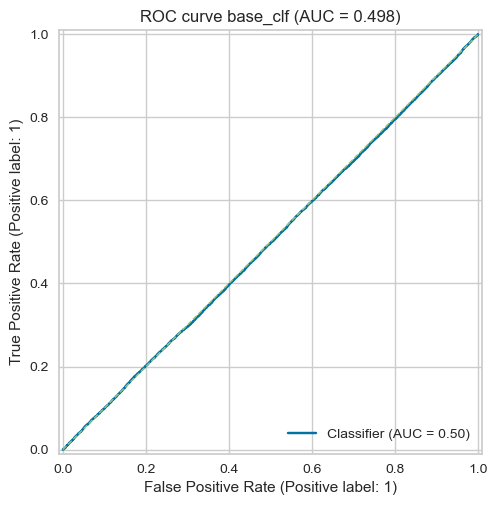

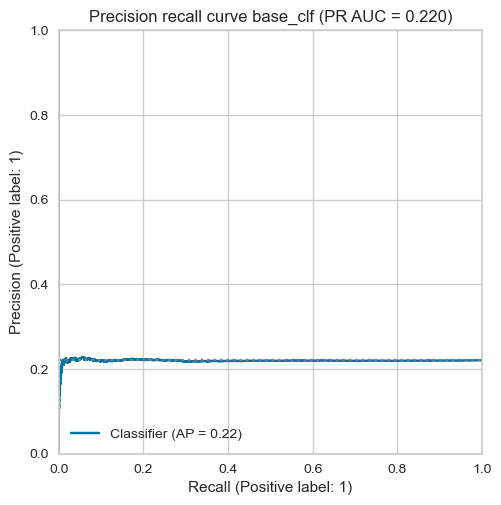

In [13]:
# Fit base model
base_clf.fit(X_train, y_train)

# Evaluate on validation
y_score_val = positive_scores(base_clf, X_val)
metrics_base = auc_report(y_val, y_score_val, name="base_clf", plot=True)

In [14]:
# Five patients: raw pre-calibration score, predicted label, actual label
tbl5 = (
    pd.DataFrame(
        {
            "raw_score": positive_scores(base_clf, X_val),            #raw scores = certainity that our predicted value is correct 
            "actual": y_val.loc[X_val.index].astype(int),
        },
        index=X_val.index,
    )
    .assign(predicted=lambda d: (d["raw_score"] >= 0.50).astype(int))  # threshold before calibration
    .round({"raw_score": 3})
    .sample(n=10, random_state=7)
    .reset_index()
    .rename(columns={"index": "patient"})
    .loc[:, ["patient", "raw_score", "predicted", "actual"]]
)

display(tbl5)


,patient,raw_score,predicted,actual
0,724473,0.497,0,1
1,58035,0.497,0,0
2,144280,0.507,1,1
3,466290,0.502,1,0
4,488115,0.492,0,1
5,260518,0.504,1,0
6,253551,0.504,1,0
7,668342,0.495,0,0
8,821411,0.502,1,0
9,779582,0.506,1,0


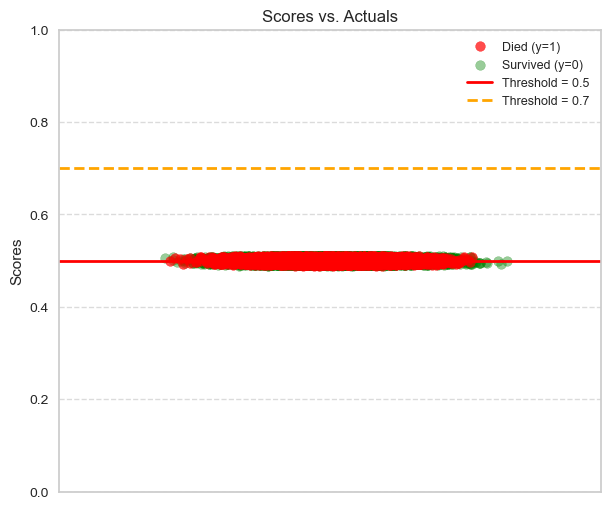

In [32]:
# Data for the plot using variables from the preceding cells
scores = positive_scores(base_clf, X_val)
actuals = y_val

# Separate scores for actual positive (died=1) and negative (survived=0) cases
scores_positive = scores[actuals == 1]  # Patients who died
scores_negative = scores[actuals == 0]  # Patients who survived

# Generate random jitter for the x-axis
jitter_strength = 0.03
jitter_positive = np.random.normal(0, jitter_strength, len(scores_positive))
jitter_negative = np.random.normal(0, jitter_strength, len(scores_negative))

# 3. Create the plot
fig, ax = plt.subplots(figsize=(7, 6))
scatter_survived = ax.scatter(jitter_negative, scores_negative, color='green', alpha=0.4, label='Survived (y=0)')
scatter_died = ax.scatter(jitter_positive, scores_positive, color='red', alpha=0.7, label='Died (y=1)')

# Add threshold lines
line_50 = ax.axhline(y=0.5, color='red', linestyle='-', linewidth=2, label='Threshold = 0.5')
line_80 = ax.axhline(y=0.7, color='orange', linestyle='--', linewidth=2, label='Threshold = 0.7')

ax.set_title('Scores vs. Actuals')
ax.set_ylabel('Scores')
ax.set_ylim(0, 1)
ax.set_xticks([])
ax.set_xlim(-0.2, 0.2) # Set fixed x-axis limits to control the visual spread
ax.legend(handles=[scatter_died, scatter_survived, line_50, line_80], fontsize=9, loc='upper right')

ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# 6. Recalibrating the Scores

**IMPORTANT: Interpreting Survival Probabilities for Clinical Use**

Our model predicts **survival probability**:
- **High score (e.g., 0.8)** = 80% chance of survival → **Low risk** patient
- **Low score (e.g., 0.2)** = 20% chance of survival → **High risk** patient

For clinical interventions, we want to identify **high-risk patients** (those likely to die), which corresponds to **LOW survival probabilities**.

**Two approaches for threshold-based decisions:**
1. **Threshold on LOW scores**: Alert if `survival_prob < 0.3` (i.e., < 30% survival chance)
2. **Convert to death risk**: `death_risk = 1 - survival_prob`, then alert if `death_risk > 0.7`

The rest of this notebook uses standard RAI framework conventions (where high scores indicate the "positive class" = survived). Keep this interpretation in mind when setting thresholds!

---

**Why Calibrate?**

**1. Reliable probabilities**  
- Turns raw scores into real probabilities  
- Ensures predictions match observed outcome frequencies  

**2. Better clinical decisions**  
- Essential when risk values guide medical choices  
- Supports thresholds with clear clinical meaning  

**3. Trust and adoption**  
- Builds trust in AI decisions  
- Enables safer patient outcomes

In [ ]:
# Calibrate probabilities using CV on training data
# Using the best model selected above
calibrated_clf = CalibratedClassifierCV(
    estimator=best_model,
    method="sigmoid",
    cv=5
)
print(f"Calibrating {best_model_name}...")
calibrated_clf.fit(X_train, y_train)
print("✓ Calibration complete")

CalibratedClassifierCV(cv=5,
                       estimator=Pipeline(steps=[('prep',
                                                  ColumnTransformer(remainder='passthrough',
                                                                    transformers=[('num',
                                                                                   Pipeline(steps=[('imputer',
                                                                                                    SimpleImputer(strategy='median')),
                                                                                                   ('scaler',
                                                                                                    StandardScaler())]),
                                                                                   ['age',
                                                                                    'cholesterol_level',
                                                                                    'treatment_duration_days']),
                                                                                  ('bin',
                                                                                   Pipeline(steps=[('imputer',
                                                                                                    SimpleImputer(strategy='most_frequent'))]),
                                                                                   ['...
                                                                                    'region_North',
                                                                                    'region_South',
                                                                                    'region_West',
                                                                                    'treat_surgery_stage',
                                                                                    'treat_chemo_comorbid',
                                                                                    'treat_surgery_comorbid',
                                                                                    'treat_radiation_comorbid',
                                                                                    'treat_chemo_smoked',
                                                                                    'treat_radiation_smoked'])],
                                                                    verbose_feature_names_out=False)),
                                                 ('varth', VarianceThreshold()),
                                                 ('model',
                                                  LogisticRegression(class_weight='balanced',
                                                                     max_iter=200,
                                                                     random_state=42,
                                                                     solver='liblinear'))]))

,Risk_band,Patients,Avg_pred_before,Actual_death_rate,Avg_pred_after
0,Q1,2225,0.506,0.209,0.219
1,Q2,2225,0.504,0.212,0.220
2,Q3,2225,0.503,0.230,0.220
3,Q4,2225,0.502,0.217,0.220
4,Q5,2225,0.501,0.222,0.220
5,Q6,2225,0.499,0.222,0.221
6,Q7,2225,0.498,0.212,0.221
7,Q8,2225,0.497,0.236,0.221
8,Q9,2225,0.496,0.221,0.222
9,Q10,2225,0.494,0.225,0.222


Check sizes
len(X_train) = 356000 len(X_val) = 66750 len(X_test) = 22250
Rows in table sum to 22250
Points near the diagonal mean predicted risk matches observed death frequency


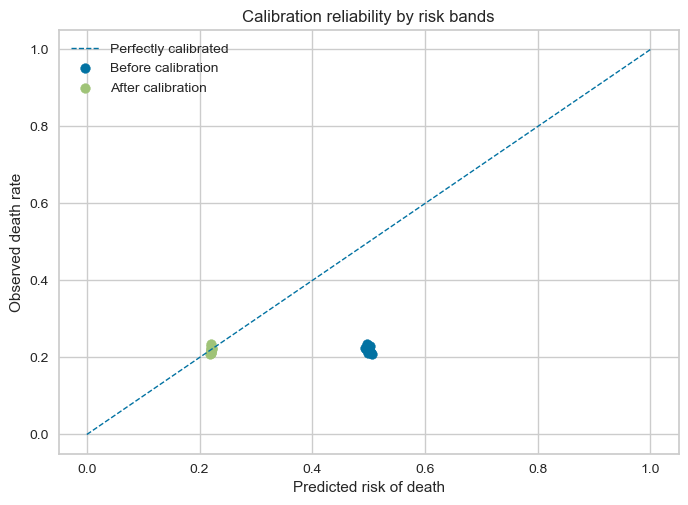

In [ ]:
# Quantile bands on test only
best_model_uncal = clone(best_model).fit(X_train, y_train)
p_before = best_model_uncal.predict_proba(X_test)[:, 1]
p_after = calibrated_clf.predict_proba(X_test)[:, 1]

# y_test: 1=survived, 0=died
# Model predicts P(survived=1) = survival probability
df_cal = pd.DataFrame({"Actual_Survived": y_test.values, "Pred_before": p_before,
                      "Pred_after": p_after}, index=X_test.index)

# 10 quantile bands with similar counts
df_cal["Survival_band"] = pd.qcut(df_cal["Pred_after"], q=10, labels=[
                              f"Q{i}" for i in range(1, 11)], duplicates="drop")

summary = (
    df_cal.groupby("Survival_band", observed=True)
    .agg(Patients=("Actual_Survived", "size"),
         Avg_pred_before=("Pred_before", "mean"),
         Actual_survival_rate=("Actual_Survived", "mean"),
         Avg_pred_after=("Pred_after", "mean"))
    .reset_index()
    .round(3)
)
display(summary)

print("Check sizes")
print("len(X_train) =", len(X_train), "len(X_val) =",
      len(X_val), "len(X_test) =", len(X_test))
print("Rows in table sum to", int(summary["Patients"].sum()))

# Reliability plot using the same fixed risk bands summary
print("Points near the diagonal mean predicted survival probability matches observed survival rate")
plt.figure()
plt.plot([0, 1], [0, 1], linestyle="--",
         linewidth=1, label="Perfectly calibrated")
plt.scatter(summary["Avg_pred_before"],
            summary["Actual_survival_rate"], label="Before calibration")
plt.scatter(summary["Avg_pred_after"],
            summary["Actual_survival_rate"],  label="After calibration")
plt.xlabel("Predicted survival probability")
plt.ylabel("Observed survival rate")
plt.title("Calibration reliability by survival probability bands")
plt.legend()
plt.show()

### Compare base_clf vs calibrated_clf on validation

In [ ]:
# Focus on discrimination equality and calibration improvements

# Scores
y_score_val_uncal = positive_scores(best_model, X_val)
y_score_val_cal = positive_scores(calibrated_clf, X_val)

# Discrimination
roc_uncal = roc_auc_score(y_val, y_score_val_uncal)
pr_uncal = average_precision_score(y_val, y_score_val_uncal)
roc_cal = roc_auc_score(y_val, y_score_val_cal)
pr_cal = average_precision_score(y_val, y_score_val_cal)

# Calibration
ll_uncal = log_loss(y_val, np.clip(y_score_val_uncal, 1e-6, 1 - 1e-6))
ll_cal = log_loss(y_val, np.clip(y_score_val_cal,  1e-6, 1 - 1e-6))
brier_uncal = brier_score_loss(y_val, y_score_val_uncal)
brier_cal = brier_score_loss(y_val, y_score_val_cal)

# Assemble into dataframe
metrics_df = pd.DataFrame([
    {"Metric": "ROC AUC", "Uncalibrated": roc_uncal, "Calibrated": roc_cal, "Explanation": "Ability to distinguish between classes (higher is better)"},
    {"Metric": "PR AUC", "Uncalibrated": pr_uncal, "Calibrated": pr_cal, "Explanation": "Precision-recall curve area; useful for imbalanced data"},
    {"Metric": "Log loss", "Uncalibrated": ll_uncal, "Calibrated": ll_cal, "Explanation": "Penalty for incorrect and overconfident predictions (lower is better)"},
    {"Metric": "Brier score", "Uncalibrated": brier_uncal, "Calibrated": brier_cal, "Explanation": "Mean squared error of predicted probabilities (lower is better)"},
])

display(metrics_df.style.format({"Uncalibrated": "{:.3f}", "Calibrated": "{:.3f}"}))

,Metric,Base,Calibrated,Explanation
0,ROC AUC,0.498,0.503,Ability to distinguish between classes (higher is better)
1,PR AUC,0.220,0.223,Precision-recall curve area; useful for imbalanced data
2,Log loss,0.693,0.528,Penalty for incorrect and overconfident predictions (lower is better)
3,Brier score,0.250,0.172,Mean squared error of predicted probabilities (lower is better)


# 7. Deciding where to cut off i.e. what probability is “high risk enough” to trigger an intervention?

,precision,recall,alerts_per_1000,true_pos_per_1000,FP,FN
threshold,,,,,,
0.1,0.221,1.0,1000.0,220.614,52024,0
0.2,0.221,1.0,1000.0,220.614,52024,0
0.3,0.000,0.0,0.0,0.000,0,14726
0.4,0.000,0.0,0.0,0.000,0,14726
0.5,0.000,0.0,0.0,0.000,0,14726


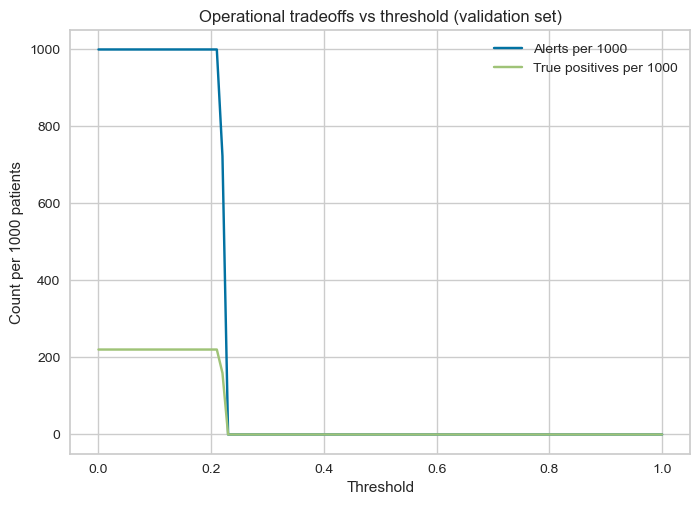

In [31]:
# Get calibrated probabilities
y_score_val = positive_scores(calibrated_clf, X_val)

# Define a grid of thresholds
thresholds = np.linspace(0, 1, 101)
rows = []
for thr in thresholds:
    y_pred = (y_score_val >= thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()
    precision = precision_score(y_val, y_pred, zero_division=0)
    recall = recall_score(y_val, y_pred, zero_division=0)
    alerts_per_1000 = 1000 * np.mean(y_pred)
    true_pos_per_1000 = 1000 * tp / len(y_val)
    rows.append({
        "threshold": thr,
        "precision": precision,
        "recall": recall,
        "alerts_per_1000": alerts_per_1000,
        "true_pos_per_1000": true_pos_per_1000,
        "FP": fp,
        "FN": fn
    })

df_thr = pd.DataFrame(rows)

# Display a few candidate thresholds for discussion
display(
    df_thr.query("threshold in [0.1, 0.2, 0.3, 0.4, 0.5]")
         .round(3)
         .set_index("threshold")
)

# Plot workload vs threshold
plt.figure()
plt.plot(df_thr["threshold"], df_thr["alerts_per_1000"], label="Alerts per 1000")
plt.plot(df_thr["threshold"], df_thr["true_pos_per_1000"], label="True positives per 1000")
plt.xlabel("Threshold")
plt.ylabel("Count per 1000 patients")
plt.title("Operational tradeoffs vs threshold (validation set)")
plt.legend()
plt.show()

## 7.1. Choosing an operating threshold

Models produce probabilities, but clinicians are the ones taking decisions, and carring the accountability of their actions.

- Setting a threshold balances in this case, among others, between missed addiction cases and unnecessary undertreatment of pain
- Clear rules make these tradeoffs explicit, explainable, and auditable!

We will run three threshold tuning analyses:
1. **Workload constrained threshold**  
  Capture the most true cases without exceeding a fixed alert capacity for the clinic
2. **Recall floor then maximize precision**  
  Guarantee a minimum case capture for safety, then pick the threshold with the fewest false alarms
3. **Cost based threshold (Bayes rule)**  
  Minimize expected harm using estimated costs for false negatives and false positives

Readouts to watch
- Threshold, precision, recall, alerts per 1000 patients, true positives per 1000, false positives, false negatives
- Connect the chosen rule to clinical policy and resource capacity

### 7.1.1. Workload constrained threshold for calibrated_clf on validation

- Alerts budget: maximum alerts per 1000 patients the clinic can review without overloading resources
- Objective: within the alerts budget, choose the threshold that yields the most true positives per 1000 so more patients at real risk are correctly flagged

In [20]:
summary.head()

,Risk_band,Patients,Avg_pred_before,Actual_OD_rate,Avg_pred_after
0,Q1,2225,0.506,0.209,0.219
1,Q2,2225,0.504,0.212,0.220
2,Q3,2225,0.503,0.230,0.220
3,Q4,2225,0.502,0.217,0.220
4,Q5,2225,0.501,0.222,0.220


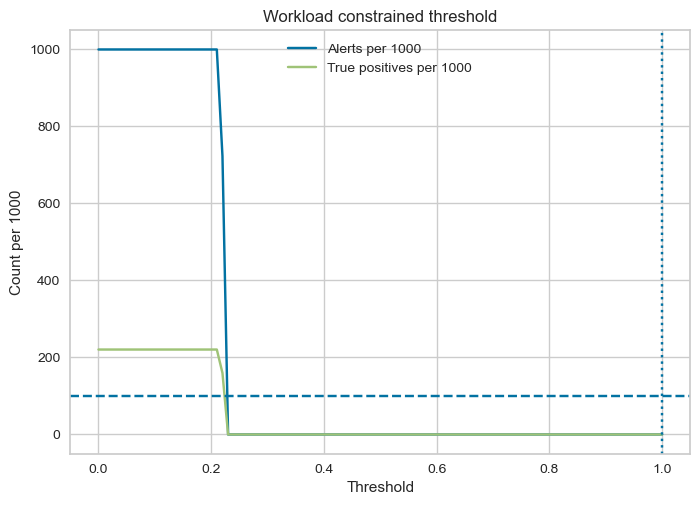

KeyError: "None of ['rule'] are in the columns"

In [ ]:
ALERTS_BUDGET = 200.0  # alerts per 1000 patients
# For lung cancer: patients flagged as high death risk for aggressive treatment/monitoring
# Higher budget than opioid use case since ~20% of patients die anyway

y_score_val = positive_scores(calibrated_clf, X_val)
res = pick_threshold_workload(y_val, y_score_val, alerts_per_1000_max=ALERTS_BUDGET)
tbl = res["table"]

plt.figure()
plt.plot(tbl["threshold"], tbl["alerts_per_1000"], label="Alerts per 1000")
plt.plot(tbl["threshold"], tbl["true_pos_per_1000"], label="True positives per 1000")
plt.axhline(ALERTS_BUDGET, linestyle="--")
plt.axvline(res["threshold"], linestyle=":")
plt.xlabel("Threshold")
plt.ylabel("Count per 1000")
plt.title("Workload constrained threshold")
plt.legend()
plt.show()

# put metrics in the rows, rules in the columns
pivot_df = summary.set_index("rule").T.reset_index().rename(columns={"index": "metric"})
display(pivot_df.round(3).set_index("metric"))

# make sure summary_df is a DataFrame
summary_df = res["summary"] if isinstance(res["summary"], pd.DataFrame) else pd.DataFrame(res["summary"])


Let's now see the risk groups by decile (bands), and visualizes the overall risk score distribution, with optional threshold overlay and decile boundaries

,n,positives,min_score,max_score,prevalence,cum_capture,alerts_per_1000,true_pos_per_1000
band,,,,,,,,
1,6675,1511,0.222,0.224,0.226,0.103,100.0,22.637
2,6675,1507,0.221,0.222,0.226,0.205,100.0,22.577
3,6675,1437,0.221,0.221,0.215,0.303,100.0,21.528
4,6675,1496,0.221,0.221,0.224,0.404,100.0,22.412
5,6675,1450,0.221,0.221,0.217,0.503,100.0,21.723
6,6675,1426,0.220,0.221,0.214,0.599,100.0,21.363
7,6675,1509,0.220,0.220,0.226,0.702,100.0,22.607
8,6675,1464,0.220,0.220,0.219,0.801,100.0,21.933
9,6675,1451,0.219,0.220,0.217,0.900,100.0,21.738


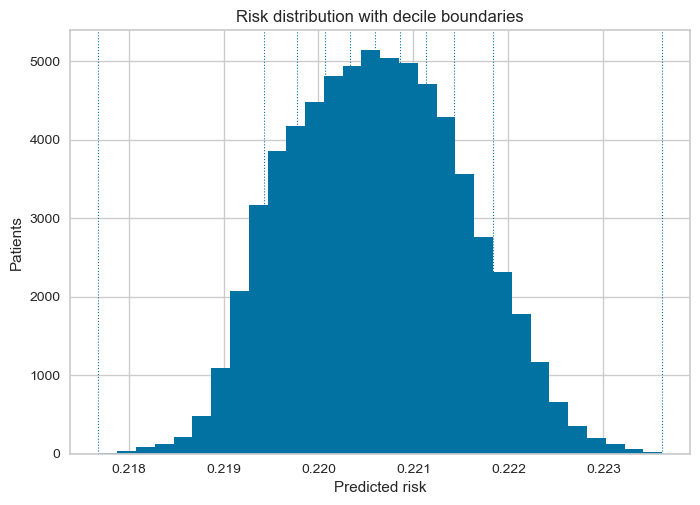

In [22]:
N_BINS = 10  # deciles by default
y_score_val = positive_scores(calibrated_clf, X_val)

# Build bands by quantiles, highest risk = band 1
bands = pd.qcut(y_score_val, q=N_BINS, labels=False, duplicates="drop")
# qcut labels lowest=0..highest=K-1, invert so 1 is highest-risk band
bands = (bands.max() - bands) + 1

df = pd.DataFrame({
    "y_true": y_val.astype(int),
    "score": y_score_val,
    "band": bands.astype(int),
})

summ = (df.groupby("band", as_index=True)
          .agg(n=("y_true","size"),
               positives=("y_true","sum"),
               min_score=("score","min"),
               max_score=("score","max"))
          .sort_index())

summ["prevalence"] = summ["positives"] / summ["n"]
summ["cum_capture"] = summ["positives"].cumsum() / df["y_true"].sum()
summ["alerts_per_1000"] = 1000.0 * summ["n"] / len(df)
summ["true_pos_per_1000"] = 1000.0 * summ["positives"] / len(df)

display(summ.round(3))

# Optional threshold overlay if you already chose one, else set THR=None
THR = None  # e.g., THR = 0.23

# Histogram of risk scores with decile edges
plt.figure()
plt.hist(df["score"], bins=30)
if THR is not None:
    plt.axvline(THR, linestyle="--")
# draw decile boundaries
edges = np.quantile(df["score"], np.linspace(0,1,N_BINS+1))
for x in edges:
    plt.axvline(x, linestyle=":", linewidth=0.8)
plt.xlabel("Predicted risk")
plt.ylabel("Patients")
plt.title("Risk distribution with decile boundaries")
plt.show()


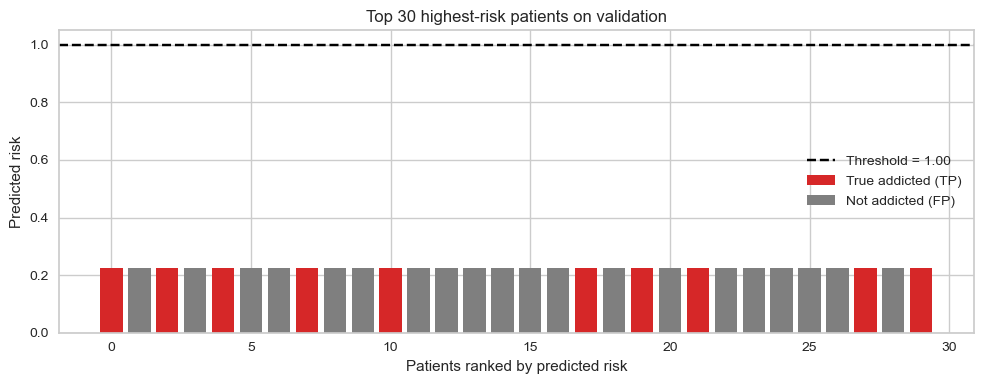

In [ ]:
THR = res["threshold"] # <- use the threshold from the previous step
y_score_val = positive_scores(calibrated_clf, X_val)
ids = np.arange(len(y_val))

# Sort patients by predicted risk
order = np.argsort(-y_score_val)
top_idx = order[:30]   # top 30 for visualization
top_scores = y_score_val[top_idx]
top_true = np.asarray(y_val)[top_idx].astype(int)

# Split indices for TP vs FP
tp_idx = np.where(top_true == 1)[0]
fp_idx = np.where(top_true == 0)[0]

plt.figure(figsize=(10, 4))
plt.bar(tp_idx, top_scores[tp_idx], color="tab:red", label="Actually died (TP)")
plt.bar(fp_idx, top_scores[fp_idx], color="tab:gray", label="Actually survived (FP)")
plt.axhline(THR, linestyle="--", color="black", label=f"Threshold = {THR:.2f}")

plt.xlabel("Patients ranked by predicted risk")
plt.ylabel("Predicted risk of death")
plt.title("Top 30 highest-risk patients on validation")
plt.legend()
plt.tight_layout()
plt.show()

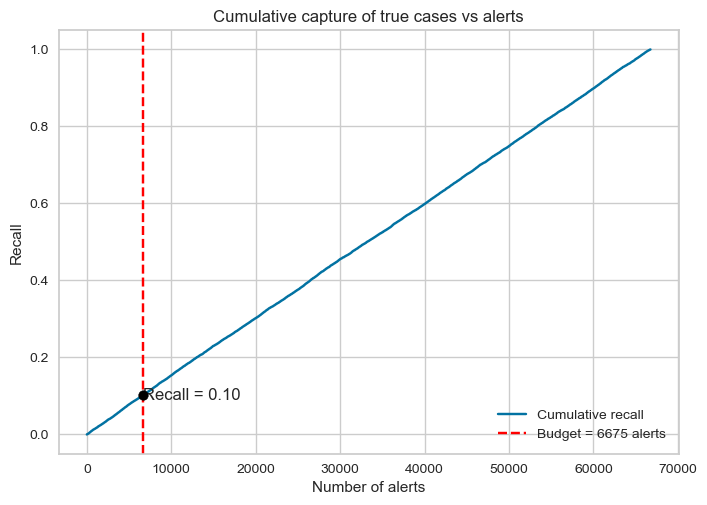

In [24]:
y_score_val = positive_scores(calibrated_clf, X_val)
order = np.argsort(-y_score_val)
y_sorted = np.asarray(y_val)[order].astype(int)

# Cumulative recall
cum_tp = np.cumsum(y_sorted)
total_pos = cum_tp[-1] if cum_tp.size else 0
alerts = np.arange(1, len(y_sorted) + 1)
recall_curve = cum_tp / total_pos if total_pos > 0 else np.zeros_like(cum_tp)

# Budget for alerts
n_budget = int(np.ceil(ALERTS_BUDGET * len(y_val) / 1000.0))

# Recall at budget
recall_at_budget = recall_curve[n_budget - 1] if n_budget > 0 and n_budget <= len(y_val) else 0.0

# Plot
plt.figure()
plt.plot(alerts, recall_curve, label="Cumulative recall")
plt.axvline(n_budget, linestyle="--", color="red", label=f"Budget = {n_budget} alerts")

# Annotate recall at budget
plt.scatter(n_budget, recall_at_budget, color="black", zorder=5)
plt.text(n_budget + 2, recall_at_budget, f"Recall = {recall_at_budget:.2f}", va="center")

plt.xlabel("Number of alerts")
plt.ylabel("Recall")
plt.title("Cumulative capture of true cases vs alerts")
plt.legend()
plt.show()

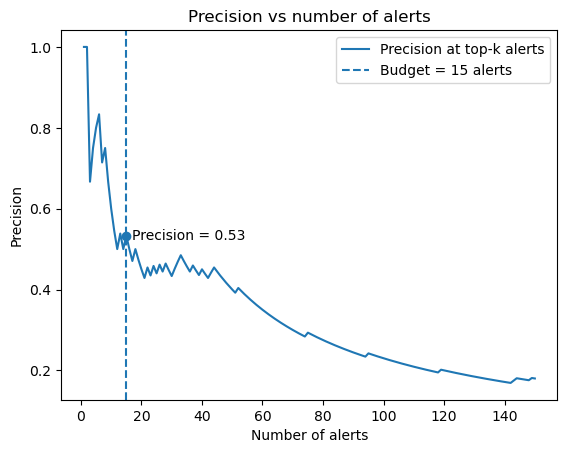

In [ ]:
# Cumulative precision at top-k alerts
alerts = np.arange(1, len(y_sorted) + 1)
cum_tp = np.cumsum(y_sorted)
precision_curve = cum_tp / alerts

# Alerts budget scaled to validation size
prec_at_budget = precision_curve[n_budget - 1] if 0 < n_budget <= len(y_sorted) else 0.0

# Plot
plt.figure()
plt.plot(alerts, precision_curve, label="Precision at top-k alerts")
plt.axvline(n_budget, linestyle="--", label=f"Budget = {n_budget} alerts")
plt.scatter(n_budget, prec_at_budget, zorder=5)
plt.text(n_budget + max(2, len(y_sorted)//100), prec_at_budget, f"Precision = {prec_at_budget:.2f}", va="center")

plt.xlabel("Number of alerts")
plt.ylabel("Precision")
plt.title("Precision vs number of alerts")
plt.legend()
plt.show()


### 7.1.2. Recall floor then maximize precision for calibrated_clf on validation

- Recall floor: minimum acceptable recall set by safety policy to limit missed addiction cases
- Precision objective: among thresholds meeting the recall floor, pick the one with highest precision to reduce unnecessary undertreatment and clinician workload

Deciding which recall floor to sue:
1. The chosen floor is a value judgment balancing patient safety vs resource burden
2. In medicine, it's often the case that missing a true case (false negative) is often much worse than raising extra alarms (false positives)
3. A recall floor enforces a safety guarantee: the model must capture at least e.g. 60% of patients who will become addicted

Among thresholds that satisfy recall ≥ 0.6, you then pick the one with the best precision, to minimize unnecessary undertreatment and workload

threshold,0.28
metric,
precision,0.459
recall,0.630
TP,17.000
FP,20.000
TN,103.000
FN,10.000
alerts_per_1000,246.667
true_pos_per_1000,113.333


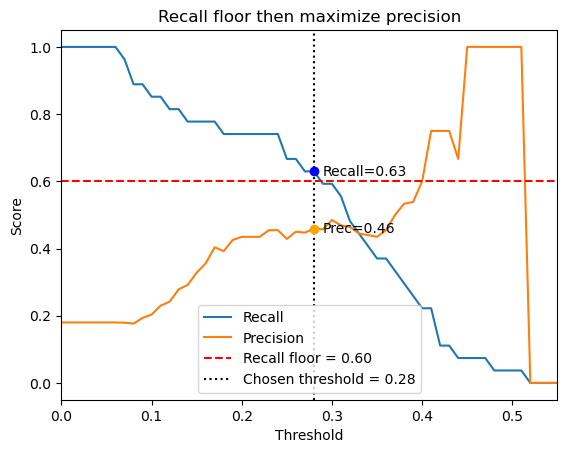

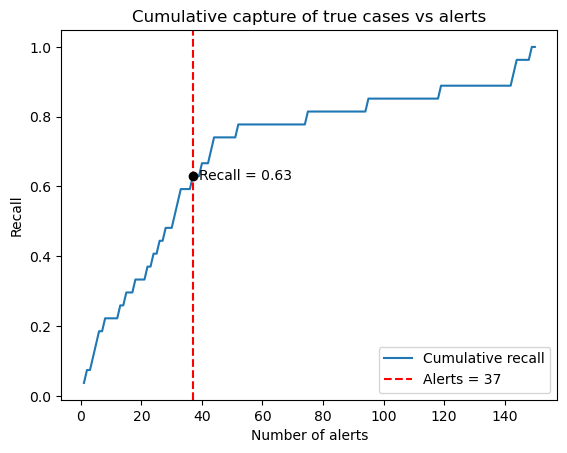

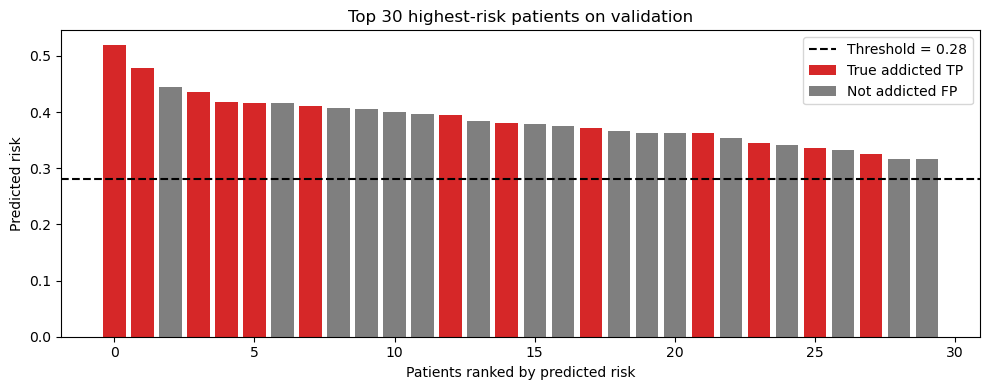

In [ ]:
# Step 1: choose threshold by recall floor
RECALL_FLOOR = 0.70 # <- judgment call
# For lung cancer: aiming to catch 70% of deaths to provide life-saving interventions
# Missing 30% of deaths is still concerning, but balances with treatment side effects
y_score_val = positive_scores(calibrated_clf, X_val)
res = pick_threshold_recall_floor(y_val, y_score_val, recall_floor=RECALL_FLOOR)
THR = float(res["threshold"])

summary_df = summary_at_threshold(y_val, y_score_val, THR)
pivot_df = summary_df.set_index("threshold").T.reset_index().rename(columns={"index": "metric"})
display(pivot_df.round(3).set_index("metric"))

# Precision and recall vs threshold with annotations
plot_recall_floor_curves(y_val, y_score_val, recall_floor=RECALL_FLOOR, chosen_threshold=THR)

# Cumulative recall vs alerts with vertical line at alerts implied by THR
plot_cumulative_recall_at_threshold(y_val, y_score_val, chosen_threshold=THR)

# Patient-level prioritization view at THR
plot_topk_at_threshold(y_val, y_score_val, chosen_threshold=THR, top_k=30)

### 7.1.3. Cost based threshold for calibrated_clf on validation

**IMPORTANT: Cost Interpretation for Survival Prediction**

Since we're predicting **survival probability** (y=1 = survived), the confusion matrix works differently:

**Confusion Matrix for Survival Prediction:**
- **TP (True Positive)**: Predicted survived (score ≥ threshold), Actually survived → ✓ Correct
- **FP (False Positive)**: Predicted survived (score ≥ threshold), Actually died → ✗ **MOST DANGEROUS!**
  - We thought patient would survive, so didn't treat aggressively → patient dies
- **TN (True Negative)**: Predicted died (score < threshold), Actually died → ✓ Correct, expected outcome
- **FN (False Negative)**: Predicted died (score < threshold), Actually survived → ✗ Over-treated
  - We thought patient would die, so treated aggressively → patient survived anyway (with side effects)

**Cost Analysis:**
- **C_FP (False Positive cost)**: HIGHEST COST - Patient dies when we predicted survival
  - Didn't provide aggressive treatment → preventable death
- **C_FN (False Negative cost)**: Lower cost - Patient survives despite our pessimistic prediction
  - Over-treated with side effects, but patient lived

**For survival prediction, FP > FN in cost!** (opposite of death risk prediction)

rule,Bayes formula,Empirical min cost
metric,,
threshold,0.090,0.170
precision,0.194,0.404
recall,0.889,0.778
TP,24.000,21.000
FP,100.000,31.000
TN,23.000,92.000
FN,3.000,6.000
alerts_per_1000,826.667,346.667
true_pos_per_1000,160.000,140.000


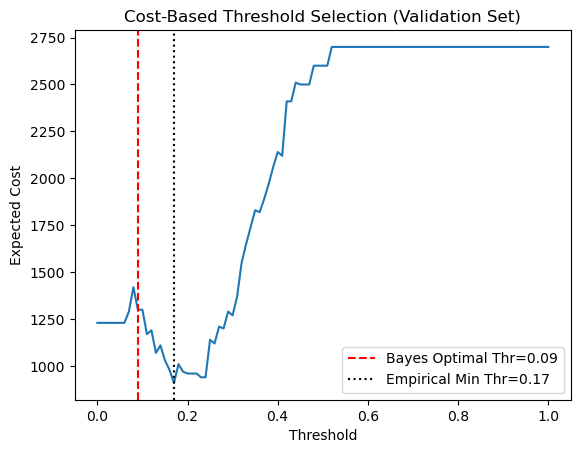

In [ ]:
# Set domain costs for lung cancer SURVIVAL prediction
# Remember: We're predicting P(survived=1), so high scores = high survival probability
C_FP = 100.0  # Cost of False Positive: Predicted survival but patient DIED
              # HIGHEST COST: Patient dies because we didn't treat aggressively enough
              # We were optimistic about survival → inadequate treatment → preventable death
              # Includes: loss of life, emotional cost, malpractice risk
              
C_FN = 10.0   # Cost of False Negative: Predicted death but patient SURVIVED  
              # Lower cost: Over-treated patient unnecessarily
              # We were pessimistic → aggressive treatment with side effects → but patient lived
              # Includes: treatment toxicity, reduced quality of life, healthcare costs
              
# Ratio: FP:FN = 10:1 (FP is 10x more costly)

# Get scores from the calibrated model on the validation set
y_score_val = positive_scores(calibrated_clf, X_val)

# Find the optimal thresholds based on cost
res = pick_threshold_cost(y_val, y_score_val, C_FP=C_FP, C_FN=C_FN)
tbl = res["table"].copy()
tbl["expected_cost"] = C_FP * tbl["FP"] + C_FN * tbl["FN"]

# Display a summary table comparing the two threshold options
summary_df = res["summary"] if isinstance(res["summary"], pd.DataFrame) else pd.DataFrame(res["summary"])

pivot_df = (
    summary_df.set_index("rule").T.reset_index().rename(columns={"index": "metric"})
)

display(pivot_df.round(3).set_index("metric"))

# Plot expected cost vs. threshold
plt.figure()
plt.plot(tbl["threshold"], tbl["expected_cost"])
plt.xlabel("Threshold")
plt.ylabel("Expected Cost")
plt.title("Cost-Based Threshold Selection (Validation Set)")

# Annotate the two optimal thresholds found
t_formula = res["threshold_formula"]
t_emp = res["threshold_empirical"]
plt.axvline(t_formula, linestyle="--", color="red", label=f"Bayes Optimal Thr={t_formula:.2f}")
plt.axvline(t_emp, linestyle=":", color="black", label=f"Empirical Min Thr={t_emp:.2f}")
plt.legend()
plt.show()


Visualizing performance at the empirical cost-based threshold of 0.170:


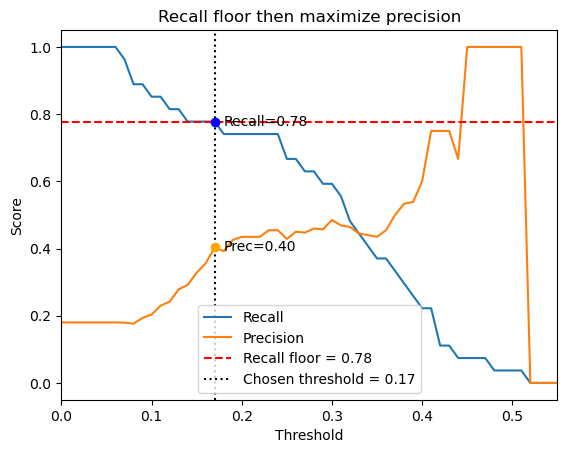

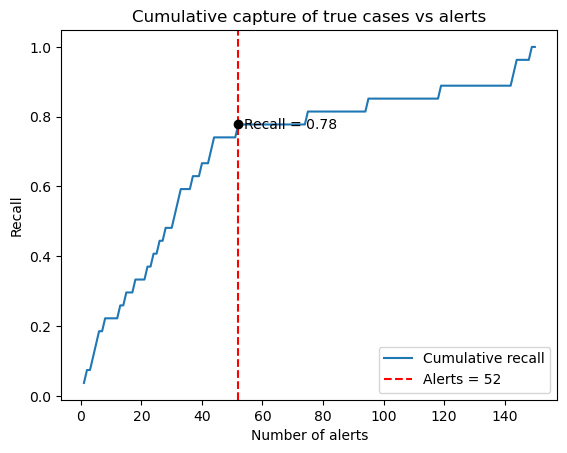

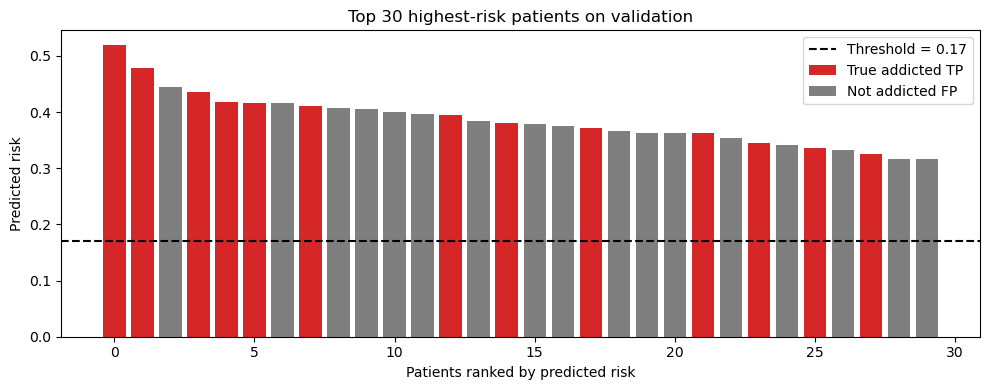

In [ ]:
# Get the empirically optimal threshold from the previous analysis
THR = res["threshold_empirical"]

# For visualization, we need a "recall_floor" to draw the horizontal line.
# We'll use the actual recall achieved at our chosen cost-based threshold.
y_pred_val = (y_score_val >= THR).astype(int)
recall_at_thr = recall_score(y_val, y_pred_val)

print(f"Visualizing performance at the empirical cost-based threshold of {THR:.3f}:")
plot_recall_floor_curves(y_val, y_score_val, recall_floor=recall_at_thr, chosen_threshold=THR)
plot_cumulative_recall_at_threshold(y_val, y_score_val, chosen_threshold=THR)
plot_topk_at_threshold(y_val, y_score_val, chosen_threshold=THR, top_k=30)


# 8. Final Threshold Selection and Test Set Evaluation

This is a crucial step that often involves discussion with clinical stakeholders to align the model's operating point with clinical goals, patient safety requirements, and resource availability

| Thresholding Method | Objective | Pros (Best for...) | Cons (Potential Risks) |
| :--- | :--- | :--- | :--- |
| **1. Workload Constrained** | Maximize TP (addiction risk) under a fixed (alert) budget | Good for limited resources, ensuring Ops stability | A low budget will miss many high-risk patients |
| **2. Recall Floor** | Maximize precision (TP vs. FP) while holding a minimum recall rate (breath) | Acts as a safety net, ensuring a minimum capture rate | Increases false alarms e.g. workloads from alternative treatments, untreated pain |
| **3. Cost-Based** | Minimize total expected cost by assigning costs to errors | Provides a formal f/ work to balance different clinical errors | Highly dependent on accurate cost estimates (can be subjective) |

1. Compute the candidate threshold (THR) for each policy on the validation set
2. Compare them on consistent operational metrics and expected cost
3. Lock the final threshold using the same (THR) variable, to get an unbiased estimate

In [ ]:
# Thresholds are derived on validation, comparison is on test

# Scores
y_score_val = positive_scores(calibrated_clf, X_val)
y_score_test = positive_scores(calibrated_clf, X_test)

# Derive thresholds on validation only, for the three methods
res_rec  = pick_threshold_recall_floor(y_val, y_score_val, recall_floor=RECALL_FLOOR)
thr_rec  = float(res_rec["threshold"])

res_work = pick_threshold_workload(y_val, y_score_val, alerts_per_1000_max=ALERTS_BUDGET)
thr_work = float(res_work["threshold"])

res_cost = pick_threshold_cost(y_val, y_score_val, C_FP=C_FP, C_FN=C_FN)
thr_cost_emp = float(res_cost["threshold_empirical"])

# Compare policies on the unseen test set using the frozen (validation) thresholds
rows = []
for approach, thr in [
    ("1. Workload budget", thr_work),
    ("2. Recall floor",    thr_rec),
    ("3. Cost min emp",    thr_cost_emp),
]:
    s = summary_at_threshold(y_test, y_score_test, thr).iloc[0].to_dict()
    s.update({
        "approach": approach,
        "expected_cost": float(C_FP * s["FP"] + C_FN * s["FN"]),
    })
    rows.append(s)

test_compare = (
    pd.DataFrame(rows)[
        ["approach", "threshold", "precision", "recall",
         "alerts_per_1000", "true_pos_per_1000", "TP", "FP", "FN", "expected_cost"]
    ]
    .sort_values("approach")
    .reset_index(drop=True)
)

pivot_df = (
    test_compare.set_index("approach").T.reset_index().rename(columns={"index": "metric"})
)

display(pivot_df.round(3).set_index("metric"))

# Also report threshold-independent curve metrics on test for context
test_roc_auc = float(roc_auc_score(y_test, y_score_test))
test_pr_auc  = float(average_precision_score(y_test, y_score_test))
print(f"Test ROC AUC={test_roc_auc:.3f}  |  Test PR AUC={test_pr_auc:.3f}")

approach,1. Workload budget,2. Recall floor,3. Cost min emp
metric,,,
threshold,0.380,0.280,0.170
precision,0.667,0.294,0.348
recall,0.222,0.556,0.889
alerts_per_1000,60.000,340.000,460.000
true_pos_per_1000,40.000,100.000,160.000
TP,2.000,5.000,8.000
FP,1.000,12.000,15.000
FN,7.000,4.000,1.000
expected_cost,710.000,520.000,250.000


Test ROC AUC=0.764  |  Test PR AUC=0.445


Based on this scenario:

- **Workload Constraint (THR = 0.38)**: Offers the highest precision (0.667) but the lowest recall (0.222), missing 7 of the 9 actual OD cases. This might be operationally efficient but carries a high patient risk i.e. low coverage for all patients

- **Recall Floor (THR = 0.28)**: Guarantees a minimum level of patient safety by capturing over half the cases (recall = 0.556), at the cost of more false positive alerts i.e. more patients without opioid treatment (alternative treatments $$$)

- **Cost-Based (THR = 0.17)**: Provides the highest recall (0.889) and lowest "expected cost" based on our 10:1 cost ratio. However, it generates the most alerts (460 per 1000 patients), which may not be operationally feasible

In [ ]:
test_compare = test_compare.sort_values('approach').reset_index(drop=True)

# Extract stats for each approach from the DataFrame
workload_stats = test_compare.iloc[0]
recall_stats = test_compare.iloc[1]
cost_stats = test_compare.iloc[2]

# Calculate total positive cases in the test set
total_pos_test = workload_stats['TP'] + workload_stats['FN']

# Dynamic markdown with increased font size using HTML <div>
markdown_text = f"""
* **Workload Constraint (THR = {workload_stats['threshold']:.2f}):** Offers the highest precision ({workload_stats['precision']:.3f}) but the lowest recall ({workload_stats['recall']:.3f}), missing {workload_stats['FN']:.0f} of the {total_pos_test:.0f} actual death cases. This might be operationally efficient but carries a high patient risk
* **Recall Floor (THR = {recall_stats['threshold']:.2f}):** Guarantees a minimum level of patient safety by capturing over half the cases (recall = {recall_stats['recall']:.3f}), at the cost of more false positive alerts
* **Cost-Based (THR = {cost_stats['threshold']:.2f}):** Provides the highest recall ({cost_stats['recall']:.3f}) and lowest "expected cost" based on our 10:1 cost ratio. However, it generates the most alerts ({cost_stats['alerts_per_1000']:.0f} per 1000 patients), which may not be operationally feasible
"""

display(Markdown(markdown_text))


* **Workload Constraint (THR = 0.38):** Offers the highest precision (0.667) but the lowest recall (0.222), missing 7 of the 9 actual OD cases. This might be operationally efficient but carries a high patient risk
* **Recall Floor (THR = 0.28):** Guarantees a minimum level of patient safety by capturing over half the cases (recall = 0.556), at the cost of more false positive alerts
* **Cost-Based (THR = 0.17):** Provides the highest recall (0.889) and lowest "expected cost" based on our 10:1 cost ratio. However, it generates the most alerts (460 per 1000 patients), which may not be operationally feasible


**Potential Decision:** For this clinical use case, patient safety is paramount. Missing a potential opioid use disorder case (a False Negative) has a significantly higher societal and health cost than a false alarm (a False Positive). Therefore, we will adopt the **2. Recall Floor threshold** of 0.28.

This choice ensures we identify a majority of at-risk patients (recall > 0.5) while maintaining a manageable number of alerts for clinical review

In [ ]:
# --- Scores and validation-derived thresholds (from your original code) ---
y_score_val = positive_scores(calibrated_clf, X_val)
y_score_test = positive_scores(calibrated_clf, X_test)

res_rec  = pick_threshold_recall_floor(y_val, y_score_val, recall_floor=RECALL_FLOOR)
thr_rec  = float(res_rec["threshold"])

res_work = pick_threshold_workload(y_val, y_score_val, alerts_per_1000_max=ALERTS_BUDGET)
thr_work = float(res_work["threshold"])

res_cost = pick_threshold_cost(y_val, y_score_val, C_FP=C_FP, C_FN=C_FN)
thr_cost_emp = float(res_cost["threshold_empirical"])

# --- Find the F1-optimal threshold on the VALIDATION set ---
thresholds_f1 = np.linspace(0.01, 0.99, 100)
f1_scores_val = [f1_score(y_val, (y_score_val >= thr).astype(int)) for thr in thresholds_f1]
thr_f1_optimal = thresholds_f1[np.argmax(f1_scores_val)]


# --- Compare all policies on the TEST set, now including F1 score ---
rows = []
# Add the new F1-optimized approach to the list
approaches = [
    ("1. Workload budget", thr_work),
    ("2. Recall floor",    thr_rec),
    ("3. Cost min emp",    thr_cost_emp),
    ("4. F1 Optimized",    thr_f1_optimal)
]

for approach, thr in approaches:
    # Get the standard summary metrics on the test set
    s = summary_at_threshold(y_test, y_score_test, thr).iloc[0].to_dict()
    
    # Calculate the F1 score on the test set for this threshold
    y_pred_test = (y_score_test >= thr).astype(int)
    f1 = f1_score(y_test, y_pred_test)
    
    # Update the dictionary with all relevant info
    s.update({
        "approach": approach,
        "expected_cost": float(C_FP * s["FP"] + C_FN * s["FN"]),
        "F1 Score": f1
    })
    rows.append(s)

# Create the final comparison DataFrame, now including the "F1 Score" column
test_compare = (
    pd.DataFrame(rows)[
        ["approach", "threshold", "precision", "recall", "F1 Score",
         "alerts_per_1000", "true_pos_per_1000", "TP", "FP", "FN", "expected_cost"]
    ]
    .sort_values("approach")
    .reset_index(drop=True)
)

# Pivot the DataFrame for the final transposed view
pivot_df = (
    test_compare.set_index("approach").T.reset_index().rename(columns={"index": "metric"})
)

display(pivot_df.round(3).set_index("metric"))

# --- Original threshold-independent metrics ---
test_roc_auc = float(roc_auc_score(y_test, y_score_test))
test_pr_auc  = float(average_precision_score(y_test, y_score_test))
print(f"Test ROC AUC={test_roc_auc:.3f}  |  Test PR AUC={test_pr_auc:.3f}")

approach,1. Workload budget,2. Recall floor,3. Cost min emp,4. F1 Optimized
metric,,,,
threshold,0.380,0.280,0.170,0.238
precision,0.667,0.294,0.348,0.316
recall,0.222,0.556,0.889,0.667
F1 Score,0.333,0.385,0.500,0.429
alerts_per_1000,60.000,340.000,460.000,380.000
true_pos_per_1000,40.000,100.000,160.000,120.000
TP,2.000,5.000,8.000,6.000
FP,1.000,12.000,15.000,13.000
FN,7.000,4.000,1.000,3.000


Test ROC AUC=0.764  |  Test PR AUC=0.445


--- Visualizing Final Performance on Test Set at Threshold = 0.28 ---
\n1. Precision-Recall Curve with Final Threshold and Resulting Recall


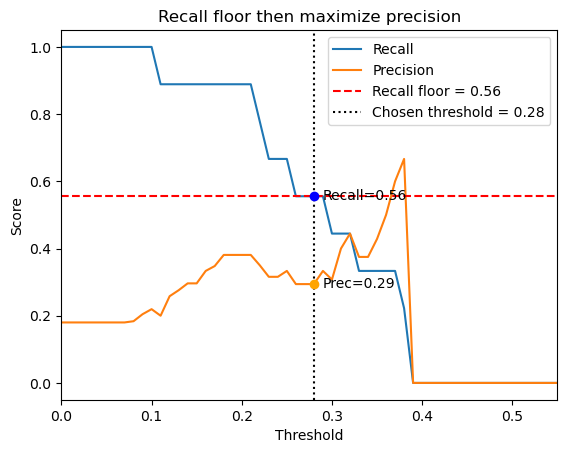

\n2. Cumulative Recall vs. Number of Alerts


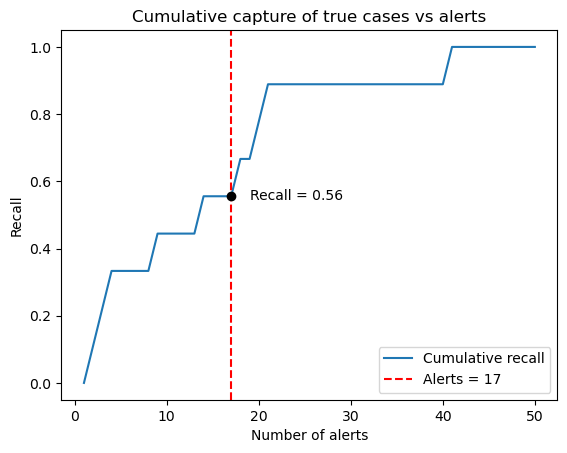

\n3. Top 30 Highest-Risk Patients View


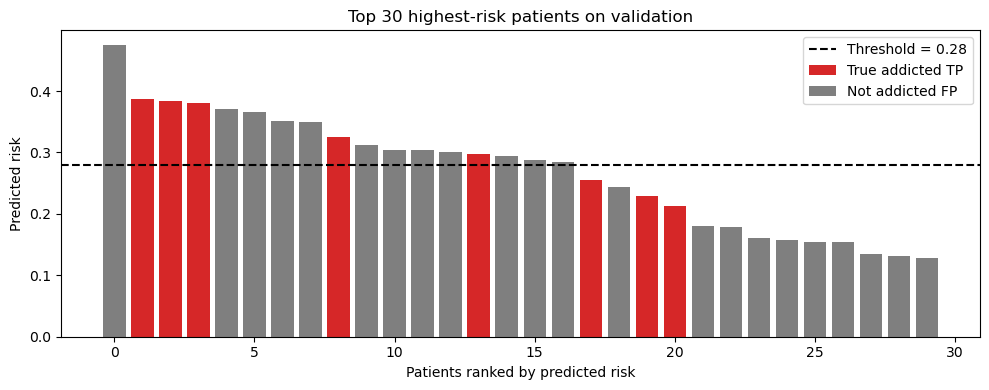

Final Calibrated Model on Test Set
PR AUC: 0.445
ROC AUC: 0.764
Prevalence p = 0.180  |  PR AUC lift = 2.47× over baseline


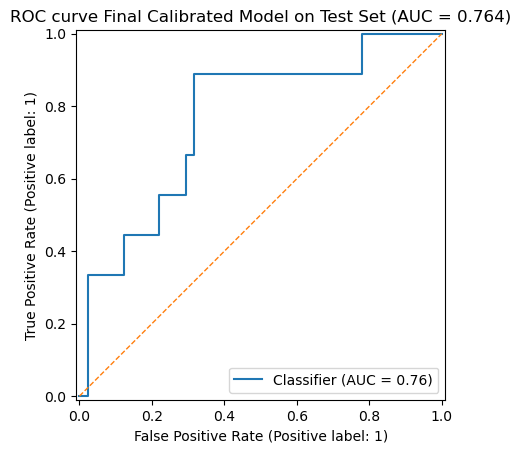

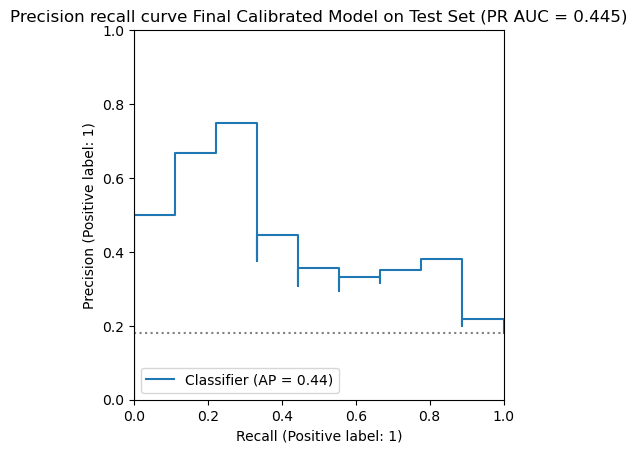

{'name': 'Final Calibrated Model on Test Set',
 'roc_auc': 0.7642276422764227,
 'pr_auc': 0.4446724308512926,
 'prevalence': 0.18,
 'lift': 2.470402393618292}

In [ ]:
from sklearn.metrics import recall_score

# --- Final Threshold Selection (from your "Recall Floor" policy) ---
# This ensures THR is set to the value derived from the validation set analysis.
THR = thr_rec

print(f"--- Visualizing Final Performance on Test Set at Threshold = {THR:.2f} ---")

# --- Step 1: Get scores and metrics on the TEST set ---
y_score_test = positive_scores(calibrated_clf, X_test)

# For the first plot, we need the actual recall achieved on the test set by our threshold.
y_pred_test = (y_score_test >= THR).astype(int)
recall_at_thr_test = recall_score(y_test, y_pred_test)


# --- Step 2: Generate the plots sequentially using your utils functions ---

# Plot 1: Recall Floor Curves
print("\\n1. Precision-Recall Curve with Final Threshold and Resulting Recall")
plot_recall_floor_curves(y_true=y_test,
                         y_score=y_score_test,
                         recall_floor=recall_at_thr_test,
                         chosen_threshold=THR)

# Plot 2: Cumulative Recall vs. Alerts
print("\\n2. Cumulative Recall vs. Number of Alerts")
plot_cumulative_recall_at_threshold(y_true=y_test,
                                     y_score=y_score_test,
                                     chosen_threshold=THR)

# Plot 3: Top-k Patient Prioritization
print("\\n3. Top 30 Highest-Risk Patients View")
plot_topk_at_threshold(y_true=y_test,
                       y_score=y_score_test,
                       chosen_threshold=THR,
                       top_k=30)

# Generate the report and plots for the final model on the test set
auc_report(y_true=y_test,
           y_score=y_score_test,
           name="Final Calibrated Model on Test Set")

# References

